# ルートを評価するために解くLPについて
- ルートが1つ与えられた後、そのルートを評価するためにLPを解く(ルートが実行可能であるとは限らない)

<!--- 各制約の違反度を変数とし、それらに重みをかけて足し合わせた関数の最小化問題とする-->
- 車両が各顧客へ到着する時刻を変数とし、その合計を最小化する問題とする
- 制約は、容量制約と時間枠制約とする
    - 容量制約は、ある区間における2つの関数の積分値(面積)の大小を比較するという形で表す(車両の積荷の量を表す区分線形関数の\[x0, xn\]までの積分値と最大容量を表す線形関数の\[x0, xn\]までの積分値)
    - 時間枠制約は、通常のVRPの定式化と同様に表す


# 前準備

## 問題例の読み込み
使用した問題例 : https://neo.lcc.uma.es/vrp/vrp-instances/description-for-files-of-solomons-instances/

In [1]:
class Customer():
    def __init__(self, x, y, d, e, l, s):
        self.x = x
        self.y = y
        self.d = d
        self.e = e
        self.l = l
        self.s = s

In [2]:
import glob

files = glob.glob("./solomon_25/*")
for file in files:
    print(file)

./solomon_25/R101.txt
./solomon_25/R103.txt
./solomon_25/R102.txt
./solomon_25/R112.txt
./solomon_25/R106.txt
./solomon_25/R107.txt
./solomon_25/R105.txt
./solomon_25/R111.txt
./solomon_25/C108.txt
./solomon_25/RC208.txt
./solomon_25/C109.txt
./solomon_25/R110.txt
./solomon_25/R104.txt
./solomon_25/R201.txt
./solomon_25/R202.txt
./solomon_25/R203.txt
./solomon_25/R207.txt
./solomon_25/R206.txt
./solomon_25/R210.txt
./solomon_25/R204.txt
./solomon_25/C208.txt
./solomon_25/R205.txt
./solomon_25/R211.txt
./solomon_25/RC108.txt
./solomon_25/RC105.txt
./solomon_25/R208.txt
./solomon_25/C205.txt
./solomon_25/C204.txt
./solomon_25/R209.txt
./solomon_25/RC104.txt
./solomon_25/RC106.txt
./solomon_25/R101.txt.distance
./solomon_25/C206.txt
./solomon_25/C207.txt
./solomon_25/RC107.txt
./solomon_25/RC103.txt
./solomon_25/C203.txt
./solomon_25/C202.txt
./solomon_25/RC102.txt
./solomon_25/C201.txt
./solomon_25/RC101.txt
./solomon_25/R109.txt
./solomon_25/C104.txt
./solomon_25/RC204.txt
./solomon_25/

In [3]:
# 問題例の選択
instance = files[0]

In [4]:
Customers = {}
with open(instance, mode="r") as f:
    for index,line in enumerate(f):
        #print(line)
        l = []
        if index==4:
            line_s = [s.strip("\n") for s in line.split("\t")][0]
            for s in line_s.split(" "):
                if s!="":
                    l.append(int(s))
            K, Q = l
        elif 9<=index<=34:
            line_s = [s.strip("\n") for s in line.split("\t")][0]
            for s in line_s.split(" "):
                if s!="":
                    l.append(int(s))
            Customers[l[0]] = Customer(*l[1:])

In [5]:
Customers["depot"] = Customer(0,0,0,0,1000,0)

In [6]:
print("\t", list(vars(Customers[0]).keys()))
for i in Customers.keys():
    print(i, end="\t")
    for key, val in vars(Customers[i]).items():
        print(val, end=" ")
    print()

	 ['x', 'y', 'd', 'e', 'l', 's']
0	35 35 0 0 230 0 
1	41 49 10 161 171 10 
2	35 17 7 50 60 10 
3	55 45 13 116 126 10 
4	55 20 19 149 159 10 
5	15 30 26 34 44 10 
6	25 30 3 99 109 10 
7	20 50 5 81 91 10 
8	10 43 9 95 105 10 
9	55 60 16 97 107 10 
10	30 60 16 124 134 10 
11	20 65 12 67 77 10 
12	50 35 19 63 73 10 
13	30 25 23 159 169 10 
14	15 10 20 32 42 10 
15	30 5 8 61 71 10 
16	10 20 19 75 85 10 
17	5 30 2 157 167 10 
18	20 40 12 87 97 10 
19	15 60 17 76 86 10 
20	45 65 9 126 136 10 
21	45 20 11 62 72 10 
22	45 10 18 97 107 10 
23	55 5 29 68 78 10 
24	65 35 3 153 163 10 
25	65 20 6 172 182 10 
depot	0 0 0 0 1000 0 


## ルートの作成

In [7]:
# 入力
## 顧客
C={} # 客の座標を保存する辞書
TW={} # 客の時間枠を保存する辞書
demand={} # 客の要求量(正の値は集荷，負の値は配達)
S={} # 客のサービス時間

for i in Customers:
    x, y = Customers[i].x, Customers[i].y
    C[i] = (x,y)
    e, l = Customers[i].e, Customers[i].l
    TW[i] = (e,l)
    demand[i] = (Customers[i].d, )
    S[i] = Customers[i].s
    """name="c"+str(i)
    x, y = Customers[i].x, Customers[i].y
    C[name] = (x,y)
    e, l = Customers[i].e, Customers[i].l
    TW[name] = (e,l)
    demand[name] = (Customers[i].d, )
    S[name] = Customers[i].s"""
#C["depot"]=(0,0)

## 車両
M = K//2 # number of vehicles
capacities = [(Q*2, ) for k in range(M)] # capacity of vehicle

In [8]:
print("Customer",C)
print("Time Window",TW)
print("Demand",demand)
print("Service Time",S)

Customer {0: (35, 35), 1: (41, 49), 2: (35, 17), 3: (55, 45), 4: (55, 20), 5: (15, 30), 6: (25, 30), 7: (20, 50), 8: (10, 43), 9: (55, 60), 10: (30, 60), 11: (20, 65), 12: (50, 35), 13: (30, 25), 14: (15, 10), 15: (30, 5), 16: (10, 20), 17: (5, 30), 18: (20, 40), 19: (15, 60), 20: (45, 65), 21: (45, 20), 22: (45, 10), 23: (55, 5), 24: (65, 35), 25: (65, 20), 'depot': (0, 0)}
Time Window {0: (0, 230), 1: (161, 171), 2: (50, 60), 3: (116, 126), 4: (149, 159), 5: (34, 44), 6: (99, 109), 7: (81, 91), 8: (95, 105), 9: (97, 107), 10: (124, 134), 11: (67, 77), 12: (63, 73), 13: (159, 169), 14: (32, 42), 15: (61, 71), 16: (75, 85), 17: (157, 167), 18: (87, 97), 19: (76, 86), 20: (126, 136), 21: (62, 72), 22: (97, 107), 23: (68, 78), 24: (153, 163), 25: (172, 182), 'depot': (0, 1000)}
Demand {0: (0,), 1: (10,), 2: (7,), 3: (13,), 4: (19,), 5: (26,), 6: (3,), 7: (5,), 8: (9,), 9: (16,), 10: (16,), 11: (12,), 12: (19,), 13: (23,), 14: (20,), 15: (8,), 16: (19,), 17: (2,), 18: (12,), 19: (17,), 20

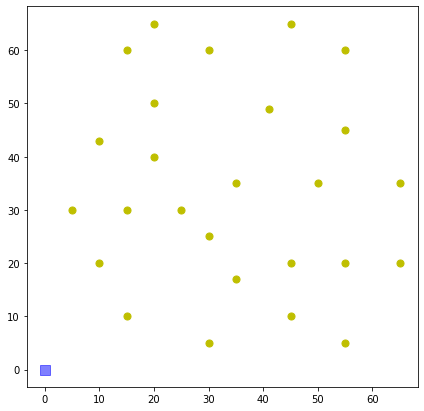

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(7,7))

G=nx.DiGraph()
nx.draw_networkx(G,pos=C,nodelist=[i for i in C if i != "depot"],node_color="y",node_size=50,with_labels=True,edge_color="k",width=1)
nx.draw_networkx(G,pos=C,nodelist=["depot"],node_color="blue",node_shape='s',alpha=0.5,node_size=100,with_labels=True,edge_color="k",width=1)

plt.show()

In [11]:
# 距離関数の定義
#def Distance(t1,t2):
#    return ((t1[0]-t2[0])**2+(t1[1]-t2[1])**2)**(0.5)
def distance(x1, y1, x2, y2):
    return ((x2-x1)**2+(y2-y1)**2)**(0.5)

# ソルバーの読み込み
import sys
sys.path.append('..')

#from vrplib.vrp_d_1m1_t_model import *
import vrplib.vrp_d_1m1_t_model as vrp

# ソルバーの実行
model = vrp.Model(file.split("/")[-1].split(".")[0]) # モデルインスタンスの生成

## 客インスタンスの生成
for i in C:
    if i == "depot":
        continue
    model += vrp.Customer(i,demand=demand[i],timewindow=TW[i],servicetime=S[i])

## 車両インスタンスの生成
for k in range(M):
    model += vrp.Vehicle("v"+str(k),capacity=capacities[k])
    
## 枝インスタンスの生成
for i in C:
    for j in C:
        if i!=j:
            dist = time = distance(*C[i],*C[j])
            model += vrp.Edge(i,j,dist,time)

In [12]:
## 最適化の実行
obj=model.optimize(IterLimit=100,TimeLimit=1,Verbose=False,OutputFlag=False)

## 得られた解の表示
print("objective value =",obj)
for v in model.vehiclesL:
    print()
    print(v)
    print(list(map(lambda x:x.name,v.routing[1:-1])))    
    for iv in map(lambda x:x.name,v.routing[1:-1]):
        print(iv)

objective value = 1211.62

Vehicle v0: {'capacity': (400,)}
173.07639 = {'distance': 173.07639, 'freight_1M1': 0.0, 'timecost': 0.0}
[0, 9, 20, 1]
0
9
20
1

Vehicle v1: {'capacity': (400,)}
36.055513 = {'distance': 36.055513, 'freight_1M1': 0.0, 'timecost': 0.0}
[14]
14

Vehicle v2: {'capacity': (400,)}
117.873959 = {'distance': 117.873959, 'freight_1M1': 0.0, 'timecost': 0.0}
[2, 21, 4]
2
21
4

Vehicle v3: {'capacity': (400,)}
67.082039 = {'distance': 67.082039, 'freight_1M1': 0.0, 'timecost': 0.0}
[5]
5

Vehicle v4: {'capacity': (400,)}
60.827625 = {'distance': 60.827625, 'freight_1M1': 0.0, 'timecost': 0.0}
[17]
17

Vehicle v5: {'capacity': (400,)}
164.129669 = {'distance': 164.129669, 'freight_1M1': 0.0, 'timecost': 0.0}
[11, 19, 10, 13]
11
19
10
13

Vehicle v6: {'capacity': (400,)}
169.362606 = {'distance': 169.362606, 'freight_1M1': 0.0, 'timecost': 0.0}
[12, 3, 24, 25]
12
3
24
25

Vehicle v7: {'capacity': (400,)}
112.504867 = {'distance': 112.504867, 'freight_1M1': 0.0, 'timecos

## ルートを1つ選ぶ

In [13]:
# Vehicle 6の巡回路を選んでいる
tour = [12, 3, 24, 25]#+["depot"]

## その他作業

In [14]:
# 使用した問題例の名称を保存
tmp = []
for s in instance[-1:0:-1]:
    if s=='/':
        break
    tmp.append(s)
instance_name = "".join(tmp[-1:0:-1])
print(instance_name)

R101.tx


# 問題を解く
2つの手法に対し、計算時間を比較

## 入力する行列、ベクトルの作成

In [ ]:
def make_A():

In [ ]:
def make_b():

In [ ]:
def make_c():

In [ ]:
def make_inputs():
    A, b, c = [], [], []
    ## ルート内の顧客の順序に関する制約
    for index, i in enumerate(tour):
        try:
            i_next = tour[index+1]
        except:
            i_next = "depot"
            continue
        #A = np.append(A, [[1 if target==i else -1 if target==i_next else 0 for target in tour]], axis=0)
        #b = np.append(b, [-distance(Customers[i].x, Customers[i].y, Customers[i_next].x, Customers[i_next].y), ], axis=0)
        A.append([1 if target==i else -1 if target==i_next else 0 for target in tour])
        b.append(-distance(Customers[i].x, Customers[i].y, Customers[i_next].x, Customers[i_next].y))
    ## 時間枠制約
    for index, i in enumerate(tour):
        #A = np.append(A, [[-1 if i==target else 0 for index_, target in enumerate(tour)]], axis=0)
        #b = np.append(b, [-Customers[i].e], axis=0)
        #A = np.append(A, [[1 if i==target else 0 for index_, target in enumerate(tour)]], axis=0)
        #b = np.append(b, [-Customers[i].l], axis=0)
        A.append([-1 if i==target else 0 for index_, target in enumerate(tour)])
        b.append(-Customers[i].e)
        A.append([1 if i==target else 0 for index_, target in enumerate(tour)])
        b.append(Customers[i].l)

## opt()の定義
与えられた定数を元にLPのモデルを作成した上でそれを解き、最適解を返す関数

In [468]:
def opt(A, b, c, instance_name, tour_len, warm_start=None, sense="MINIMIZE"):
    import gurobipy as gp
    from gurobipy import GRB
    import numpy as np
    import time
    
    # インスタンスの生成
    m = gp.Model("LP_for_VRP" + instance_name)
    # 定数を設定　←　入力として与えられる
    # 変数を設定
    """
    x_i : 顧客iへ車両が到着する時刻を表す変数
    """
    x = m.addMVar(shape=tour_len, vtype=GRB.CONTINUOUS, name="x")

    # モデルのアップデート
    m.update()
    
    # 目的関数を設定
    ## 各制約の違反度を最小化する
    m.setObjective(c @ x, sense=eval("gp.GRB."+sense))
    
    # 制約条件を設定
    if sense=="MINIMIZE":
        m.addConstr(A @ x <= b, name="c")
    elif sense=="MAXIMAZE":
        m.addConstr(A @ x >= b, name="c")

    # モデルのアップデート
    m.update()
    
    # 時間計測スタート
    start = time.time()
    
    # ホットスタートの使用
    """if warm_start is not None:
        for i in range(tour_len):
            x[i].Pstart = warm_start[i]
            #print(x[i].X)"""
    
    # 最適化
    m.optimize()
    
    # 時間計測ストップ
    elapsed_time = time.time() - start
    
    # 解の表示
    if m.Status == gp.GRB.OPTIMAL:
        for i in range(tour_len):
            print(f"車両が顧客{i}に到着する時刻は、{x[i].X}")
        print("最適値 : ", m.ObjVal)
    print('\033[34m'+f"実時間\t{elapsed_time}"+'\033[0m')
        
    return m

## ①全体を1つのLPとして解くveb.
1. ルートが与えられる
1. Primalを解く

### 1. ルートが与えられる

### 2. 全体のPrimalを解く

In [488]:
import numpy as np

## 制約式の左辺を保存する変数
A = [] #np.array([np.zeros(len(tour))])
## 制約式の右辺を保存する変数
b = [] #np.array([])

## ルート内の顧客の順序に関する制約
for index, i in enumerate(tour):
    try:
        i_next = tour[index+1]
    except:
        i_next = "depot"
        continue
    #A = np.append(A, [[1 if target==i else -1 if target==i_next else 0 for target in tour]], axis=0)
    #b = np.append(b, [-distance(Customers[i].x, Customers[i].y, Customers[i_next].x, Customers[i_next].y), ], axis=0)
    A.append([1 if target==i else -1 if target==i_next else 0 for target in tour])
    b.append(-distance(Customers[i].x, Customers[i].y, Customers[i_next].x, Customers[i_next].y))

In [490]:
## 時間枠制約
for index, i in enumerate(tour):
    #A = np.append(A, [[-1 if i==target else 0 for index_, target in enumerate(tour)]], axis=0)
    #b = np.append(b, [-Customers[i].e], axis=0)
    #A = np.append(A, [[1 if i==target else 0 for index_, target in enumerate(tour)]], axis=0)
    #b = np.append(b, [-Customers[i].l], axis=0)
    A.append([-1 if i==target else 0 for index_, target in enumerate(tour)])
    b.append(-Customers[i].e)
    A.append([1 if i==target else 0 for index_, target in enumerate(tour)])
    b.append(Customers[i].l)
    
#for index, i in enumerate(tour):
    #m.addConstr(-x[i] <= -Customers[i].e)
    #m.addConstr(x[i] <= Customers[i].l)

In [492]:
## 容量制約
integral_val = 0
A.append([0 for _ in range(len(tour))])
for index, i in enumerate(tour):
    try:
        i_next = tour[index+1]
    except:
        i_next = "depot"
    #integral_val += (x[i_next]-x[i])*sum(Customers[j].d for j in tour[:index+1])
    sum_d = sum(Customers[j].d for j in tour[:index+1])
    A[-1] = [-sum_d if i==target else sum_d if i_next==target else A[-1][index_] for index_, target in enumerate(tour)]
A[-1][0] += Q
A[-1][-1] += -Q
b.append(0)
#m.addConstr(integral_val <= (x["depot"]-x[tour[0]])*Q*2)

In [493]:
for A_i, b_i in zip(A, b):
    print(A_i, "\t", b_i)

[1, -1, 0, 0] 	 -11.180339887498949
[0, 1, -1, 0] 	 -14.142135623730951
[0, 0, 1, -1] 	 -15.0
[-1, 0, 0, 0] 	 -63
[1, 0, 0, 0] 	 73
[0, -1, 0, 0] 	 -116
[0, 1, 0, 0] 	 126
[0, 0, -1, 0] 	 -153
[0, 0, 1, 0] 	 163
[0, 0, 0, -1] 	 -172
[0, 0, 0, 1] 	 182
[181, -32, -35, -241] 	 0


In [494]:
# 定数を成形する
## 制約の数は(制約の種類)*(巡回路内の顧客の数)

## 制約式の左辺
A = np.array(A)

## 制約式の右辺
b = np.array(b)

## 目的関数の係数
c = np.array([1 for _ in range(len(tour))])

for A_i, b_i in zip(A, b):
    print(A_i, "\t", b_i)

[ 1 -1  0  0] 	 -11.180339887498949
[ 0  1 -1  0] 	 -14.142135623730951
[ 0  0  1 -1] 	 -15.0
[-1  0  0  0] 	 -63.0
[1 0 0 0] 	 73.0
[ 0 -1  0  0] 	 -116.0
[0 1 0 0] 	 126.0
[ 0  0 -1  0] 	 -153.0
[0 0 1 0] 	 163.0
[ 0  0  0 -1] 	 -172.0
[0 0 0 1] 	 182.0
[ 181  -32  -35 -241] 	 0.0


In [495]:
# opt()によってLPを解く
whole_x = opt(A, b, c, instance_name+"whole_x", len(tour))

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 12 rows, 4 columns and 18 nonzeros
Model fingerprint: 0x6dfd34e6
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0400000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.040000000e+02
車両が顧客0に到着する時刻は、[63.]
車両が顧客1に到着する時刻は、[116.]
車両が顧客2に到着する時刻は、[153.]
車両が顧客3に到着する時刻は、[172.]
最適値 :  504.0
実時間	0.017222881317138672


In [496]:
whole_x

<gurobi.Model Continuous instance LP_for_VRPR101.txwhole_x: 12 constrs, 4 vars, No parameter changes>

In [497]:
for constr in whole_x.getConstrs():
    print(constr.Pi)

0.0
0.0
0.0
-1.0
0.0
-1.0
0.0
-1.0
0.0
-1.0
0.0
0.0


## ②前半と後半をつなげるveb.
1. ルートが与えられる
1. 適当なところで前後に分ける
1. 前半後半それぞれのPrimalを解く
1. 前半と後半それぞれのPrimalの最適解を、全体のDualに入れて解く(つなげる際に必要になる制約A3を考えなければならない)
1. Primalの解を相補正条件によって復元

### 2. 適当なところで前後に分ける
- ひとまず半分くらいで分けることにする

In [498]:
threshold = len(tour)//2
#print(threshold)

former = tour[:threshold]
latter = tour[threshold:]
print(f"巡回路全体は、{tour}")
print(f"前半は、{former}")
print(f"後半は、{latter}")

巡回路全体は、[12, 3, 24, 25]
前半は、[12, 3]
後半は、[24, 25]


### 3. 前半後半それぞれのPrimalを解く

In [499]:
# 係数行列、ベクトルを整える
A1, A2, A3, b1, b2, b3, c1, c2 = [], [], [], [], [], [], [], []
## A1, A2, A3を定める
## b1, b2, b3を定める
for A_i,b_i in zip(A, b):
    if np.linalg.norm(A_i[threshold:], ord=2)==0.:
        A1.append(A_i[:threshold])
        b1.append(b_i)
    elif np.linalg.norm(A_i[:threshold], ord=2)==0.:
        A2.append(A_i[threshold:])
        b2.append(b_i)
    else:
        A3.append(A_i)
        b3.append(b_i)
## c1, c2, c3を定める
c1.append(c[:threshold])
c2.append(c[threshold:])
    
## リストからnumpy arrayに変換
A1 = np.array(A1)
A2 = np.array(A2)
A3 = np.array(A3)
b1 = np.array(b1)
b2 = np.array(b2)
b3 = np.array(b3)
c1 = np.array(c1)
c2 = np.array(c2)
for i in range(1, 4):
    print(eval("A"+str(i)))
    print(eval("b"+str(i)))
    if i <= 2:
        print(eval("c"+str(i)))

[[ 1 -1]
 [-1  0]
 [ 1  0]
 [ 0 -1]
 [ 0  1]]
[ -11.18033989  -63.           73.         -116.          126.        ]
[[1 1]]
[[ 1 -1]
 [-1  0]
 [ 1  0]
 [ 0 -1]
 [ 0  1]]
[ -15. -153.  163. -172.  182.]
[[1 1]]
[[   0    1   -1    0]
 [ 181  -32  -35 -241]]
[-14.14213562   0.        ]


In [500]:
# Gurobiによって最適解を求める
former_x = opt(A1, b1, c1, instance_name+"former_x", len(former))
latter_x = opt(A2, b2, c2, instance_name+"latter_x", len(latter))

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xf85739b4
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7900000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.790000000e+02
車両が顧客0に到着する時刻は、[63.]
車両が顧客1に到着する時刻は、[116.]
最適値 :  179.0
実時間	0.015311956405639648
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xc3974699
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+02]
Presolve removed 

### 4. 前半後半それぞれのPrimalの最適解を、全体のDualに入れて解く

In [501]:
# 変数yの非負制約をA、bに加える
## 加える行列を定義
A_ = np.eye(A.shape[0])
c_ = np.zeros(A.shape[0])
## 加える
A = np.concatenate([A, A_], axis=1)
c = np.concatenate([c, c_])

In [502]:
# 基底解の保存
basis = np.array([constr.Pi for constr in former_x.getConstrs()+latter_x.getConstrs()])
y3 = np.zeros((A.shape[0]-basis.shape[0],))
basis = np.append(basis, y3)

In [503]:
for A_i, b_i in zip(A.T, c.T):
    print(A_i, "\t", b_i)

[  1.   0.   0.  -1.   1.   0.   0.   0.   0.   0.   0. 181.] 	 1.0
[ -1.   1.   0.   0.   0.  -1.   1.   0.   0.   0.   0. -32.] 	 1.0
[  0.  -1.   1.   0.   0.   0.   0.  -1.   1.   0.   0. -35.] 	 1.0
[   0.    0.   -1.    0.    0.    0.    0.    0.    0.   -1.    1. -241.] 	 1.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 0.0
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 0.0
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	 0.0
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	 0.0
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 	 0.0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 	 0.0
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 	 0.0
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 	 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 	 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 	 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 	 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 	 0.0


In [504]:
whole_y = opt(A.T, c.T, b.T, instance_name+"whole_y", basis.shape[0], basis, "MAXIMIZE")

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 0 rows, 12 columns and 0 nonzeros
Model fingerprint: 0x735bf0b1
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 4 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Unbounded model
実時間	0.014952898025512695


### 5. Primalの解を相補正条件によって復元